In [5]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from math import log10, sqrt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageFilter
from keras_tuner import Objective
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

AUTOTUNE = tf.data.AUTOTUNE

## EDA of the Dataset

In [4]:
# Define the paths to the directories
dataset_path = "./dataset/"
train_hr_path = os.path.join(dataset_path, "train_hr")
train_lr_path = os.path.join(dataset_path, "train_lr")
val_hr_path = os.path.join(dataset_path, "val_hr")
val_lr_path = os.path.join(dataset_path, "val_lr")
test_hr_path = os.path.join(dataset_path, "test_hr")
test_lr_path = os.path.join(dataset_path, "test_lr")

# Count the number of images in each directory
def count_images(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Store the counts in a dictionary
image_counts = {
    "Total Dataset": sum(count_images(path) for path in [train_hr_path, train_lr_path, val_hr_path, val_lr_path, test_hr_path, test_lr_path]),
    "Train HR": count_images(train_hr_path),
    "Train LR": count_images(train_lr_path),
    "Validation HR": count_images(val_hr_path),
    "Validation LR": count_images(val_lr_path),
    "Test HR": count_images(test_hr_path),
    "Test LR": count_images(test_lr_path)
}

image_counts

{'Total Dataset': 2822,
 'Train HR': 942,
 'Train LR': 942,
 'Validation HR': 218,
 'Validation LR': 218,
 'Test HR': 251,
 'Test LR': 251}

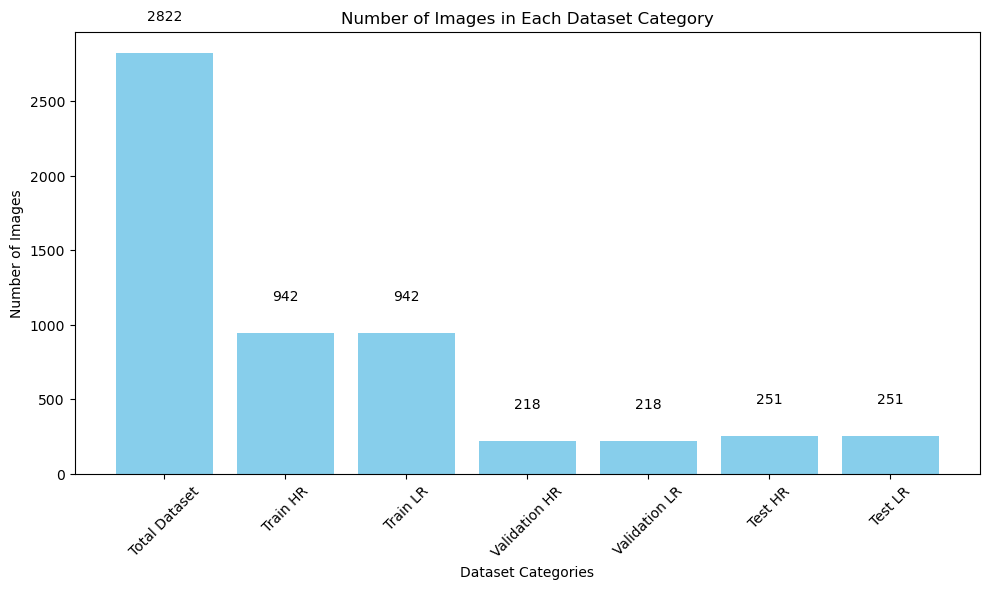

In [7]:
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color='skyblue')

# Adding annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 200, int(yval), ha='center', va='bottom')

plt.xlabel('Dataset Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Dataset Category')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

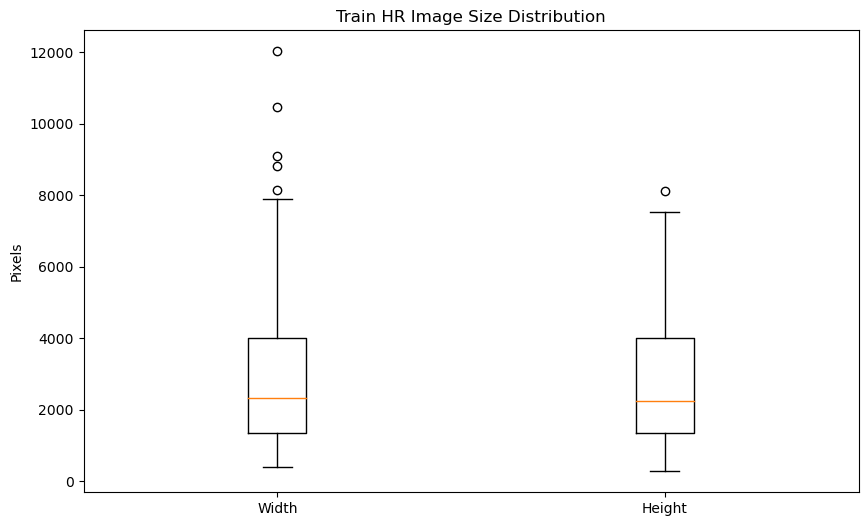

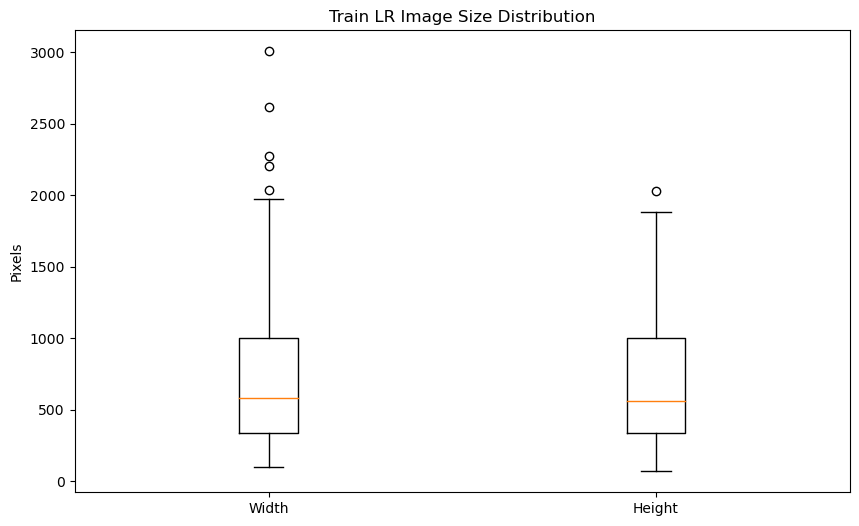

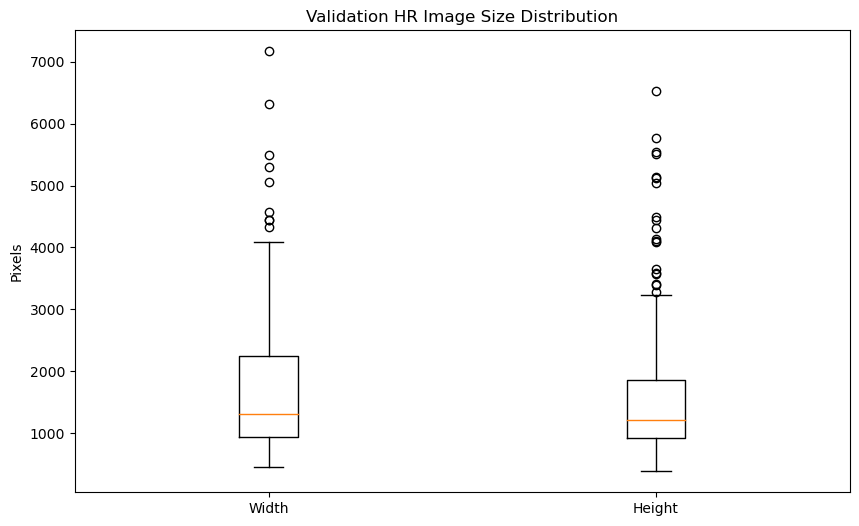

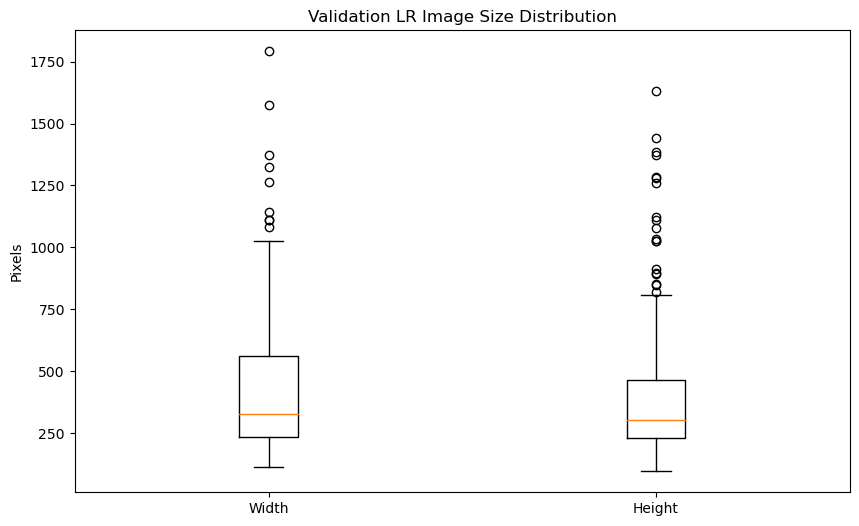

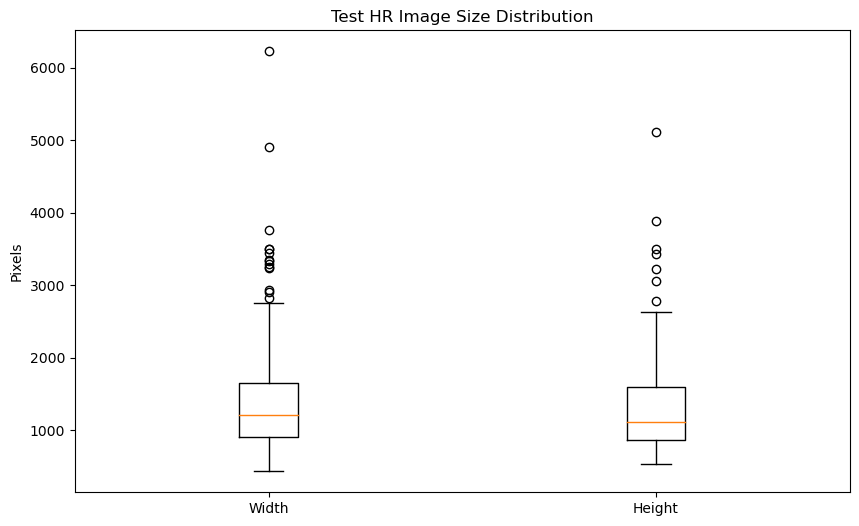

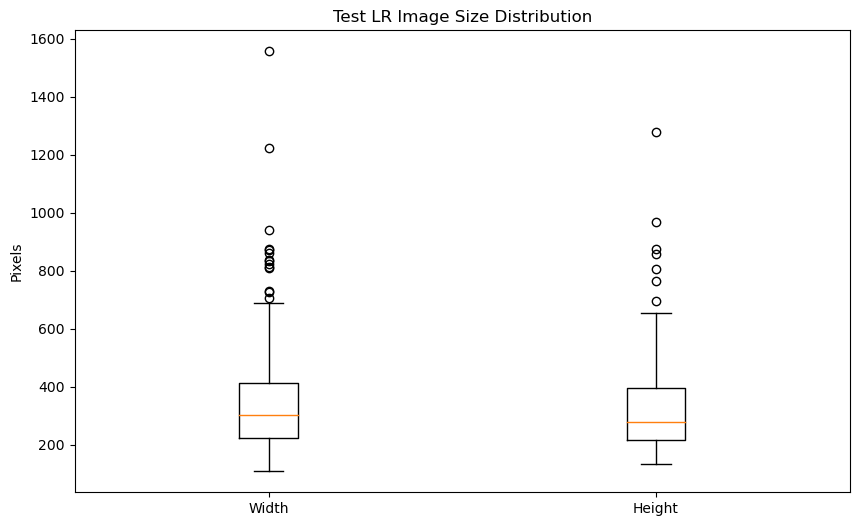

In [11]:
# Plotting image size distribution with boxplot
def plot_image_size_boxplot(sizes, title):
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 6))
    plt.boxplot([widths, heights], labels=['Width', 'Height'])
    plt.title(title)
    plt.ylabel('Pixels')
    plt.show()

plot_image_size_boxplot(train_hr_sizes, 'Train HR Image Size Distribution')
plot_image_size_boxplot(train_lr_sizes, 'Train LR Image Size Distribution')
plot_image_size_boxplot(val_hr_sizes, 'Validation HR Image Size Distribution')
plot_image_size_boxplot(val_lr_sizes, 'Validation LR Image Size Distribution')
plot_image_size_boxplot(test_hr_sizes, 'Test HR Image Size Distribution')
plot_image_size_boxplot(test_lr_sizes, 'Test LR Image Size Distribution')


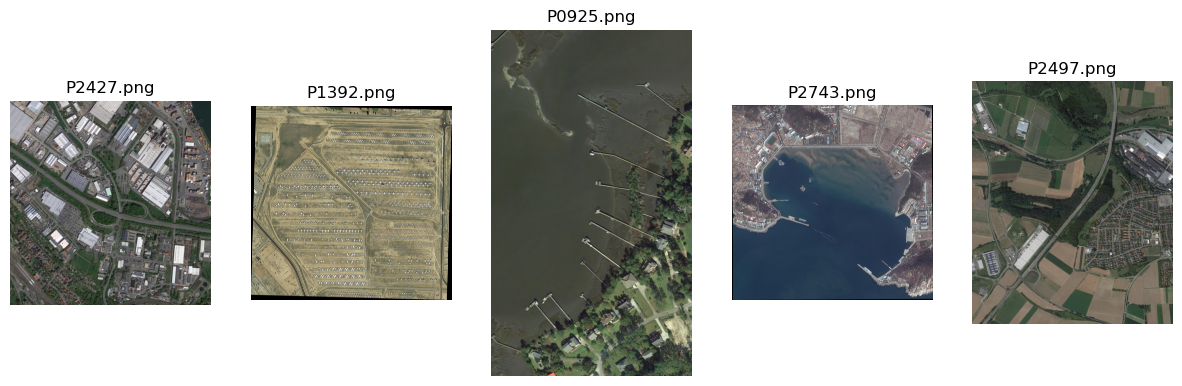

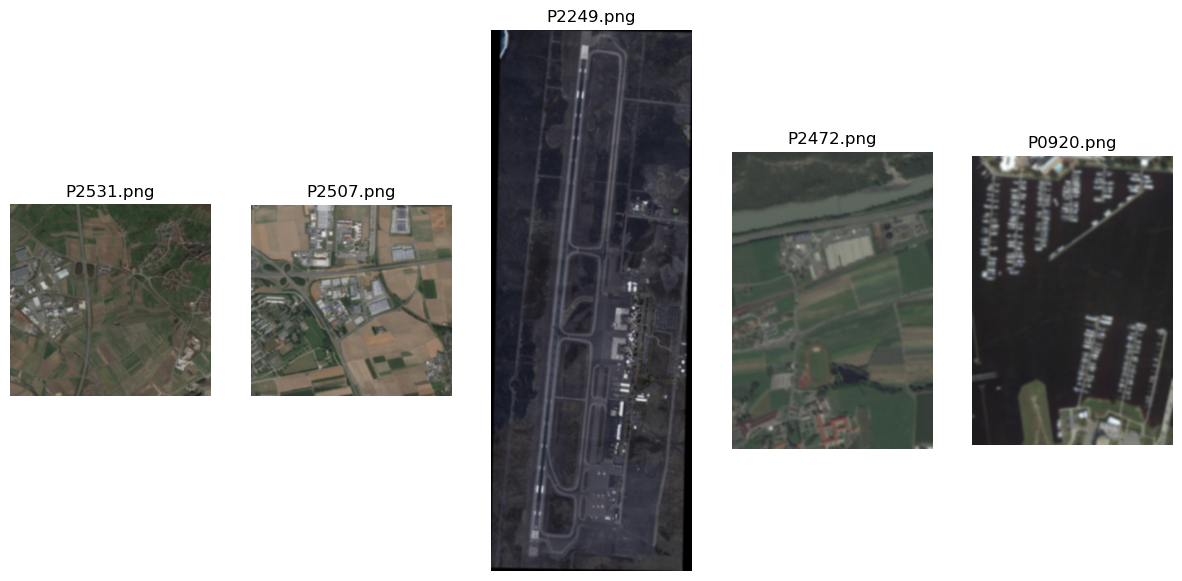

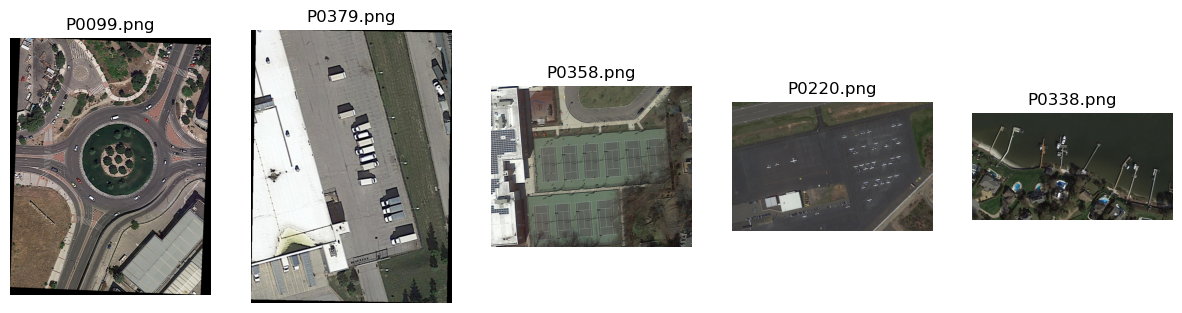

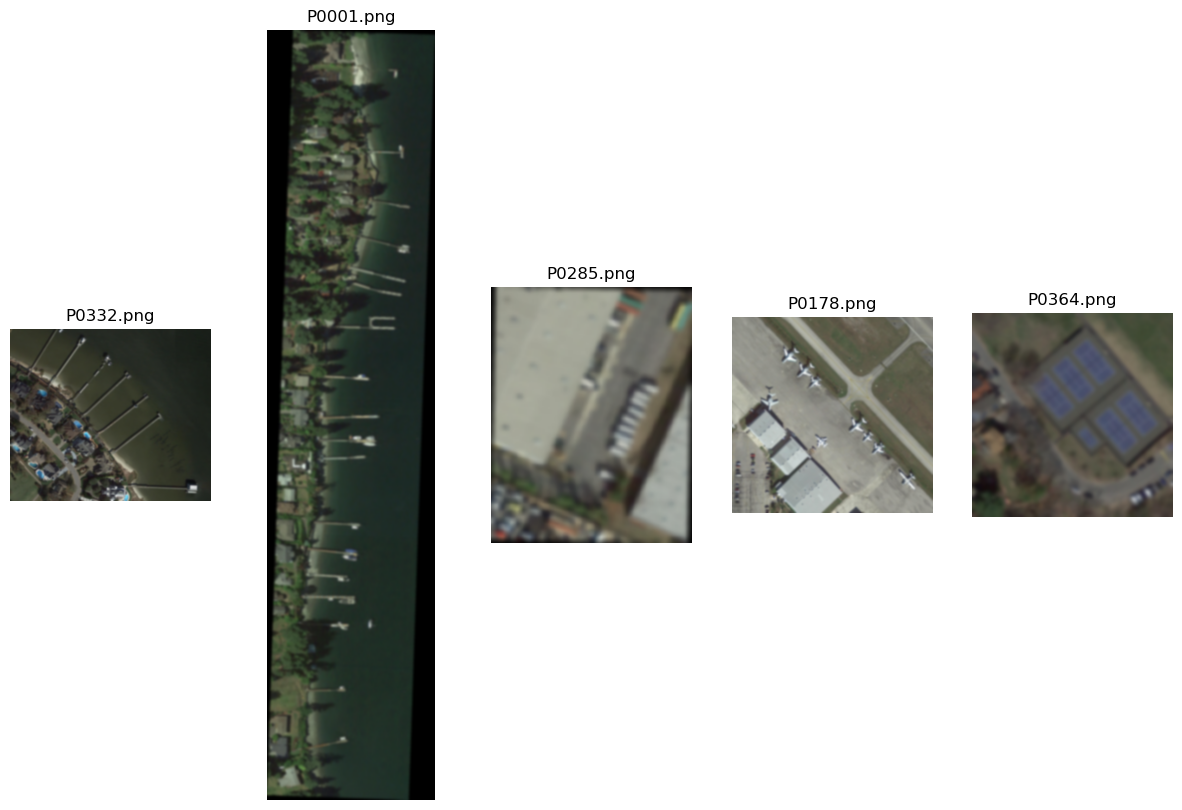

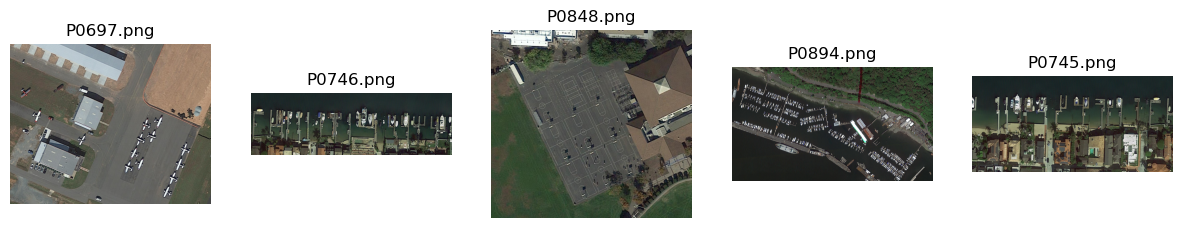

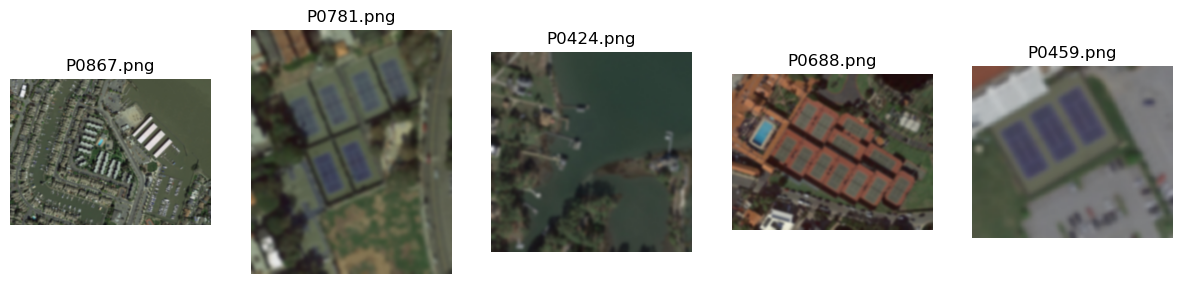

In [10]:
# Function to display sample images
def display_sample_images(directory, n=5):
    sample_files = random.sample([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))], n)
    plt.figure(figsize=(15, 10))
    for i, file in enumerate(sample_files):
        with Image.open(os.path.join(directory, file)) as img:
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(file)
    plt.show()

display_sample_images(train_hr_path, n=5)
display_sample_images(train_lr_path, n=5)
display_sample_images(val_hr_path, n=5)
display_sample_images(val_lr_path, n=5)
display_sample_images(test_hr_path, n=5)
display_sample_images(test_lr_path, n=5)


### Color Channel Analysis

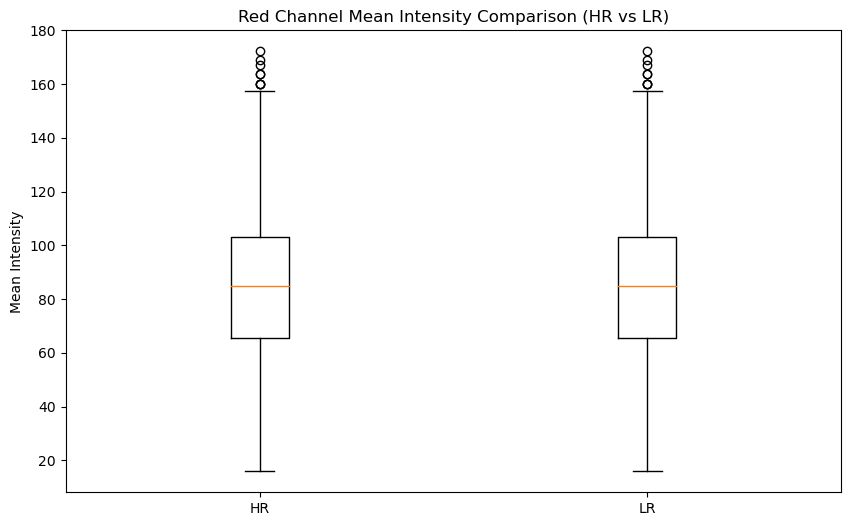

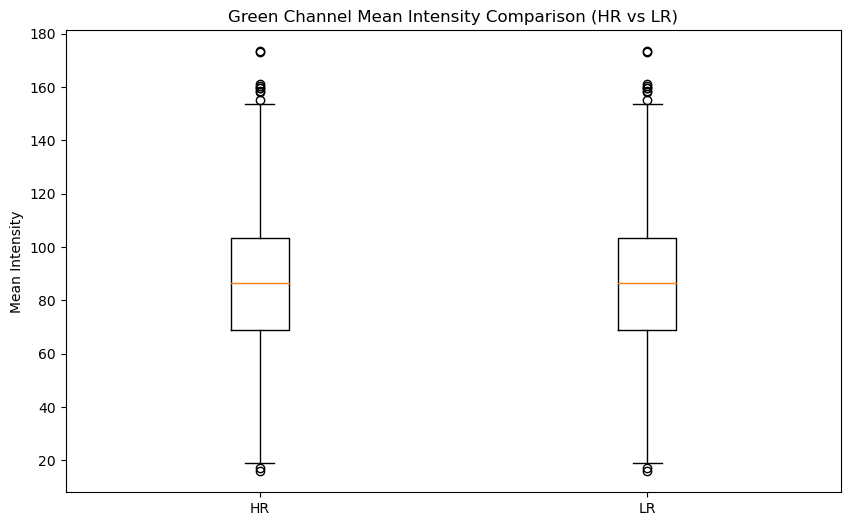

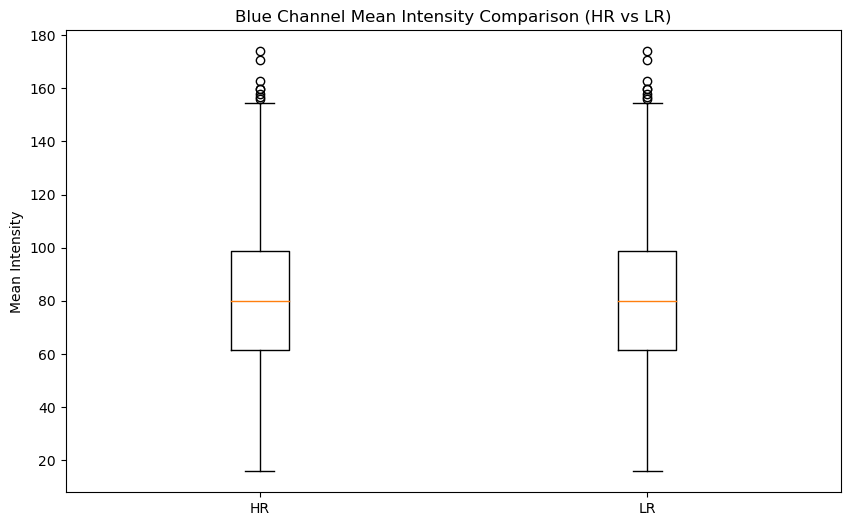

In [26]:
# Function to get color channel statistics
def get_color_channel_statistics(directory):
    red_means, green_means, blue_means = [], [], []
    red_stds, green_stds, blue_stds = [], [], []
    for file in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file)):
            with Image.open(os.path.join(directory, file)) as img:
                img_array = np.array(img)
                
                if img_array.ndim == 2:  # Grayscale image
                    red_channel = green_channel = blue_channel = img_array
                elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
                    red_channel = img_array[:, :, 0]
                    green_channel = img_array[:, :, 1]
                    blue_channel = img_array[:, :, 2]
                else:
                    continue  # Skip non-grayscale and non-RGB images
                
                red_means.append(np.mean(red_channel))
                green_means.append(np.mean(green_channel))
                blue_means.append(np.mean(blue_channel))
                
                red_stds.append(np.std(red_channel))
                green_stds.append(np.std(green_channel))
                blue_stds.append(np.std(blue_channel))
                
    return red_means, green_means, blue_means, red_stds, green_stds, blue_stds

# Get color channel statistics for each category
train_hr_red_means, train_hr_green_means, train_hr_blue_means, train_hr_red_stds, train_hr_green_stds, train_hr_blue_stds = get_color_channel_statistics(train_hr_path)
train_lr_red_means, train_lr_green_means, train_lr_blue_means, train_lr_red_stds, train_lr_green_stds, train_lr_blue_stds = get_color_channel_statistics(train_lr_path)

# Plotting color channel statistics
def plot_color_channel_statistics(hr_means, lr_means, channel_name):
    plt.figure(figsize=(10, 6))
    plt.boxplot([hr_means, lr_means], labels=['HR', 'LR'])
    plt.title(f'{channel_name} Channel Mean Intensity Comparison (HR vs LR)')
    plt.ylabel('Mean Intensity')
    plt.show()

plot_color_channel_statistics(train_hr_red_means, train_lr_red_means, 'Red')
plot_color_channel_statistics(train_hr_green_means, train_lr_green_means, 'Green')
plot_color_channel_statistics(train_hr_blue_means, train_lr_blue_means, 'Blue')


### Correlation between HR and LR images

In [27]:

# Function to calculate pixel intensity correlation
def calculate_correlation(hr_directory, lr_directory, n=10):
    correlations = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            hr_img_flat = hr_img_array.flatten()
            lr_img_flat = lr_img_array.flatten()
            correlation = np.corrcoef(hr_img_flat, lr_img_flat)[0, 1]
            correlations.append(correlation)
    return np.mean(correlations)

average_correlation = calculate_correlation(train_hr_path, train_lr_path)
print(f'Average correlation between HR and LR images: {average_correlation}')


Average correlation between HR and LR images: 0.8505911157889638


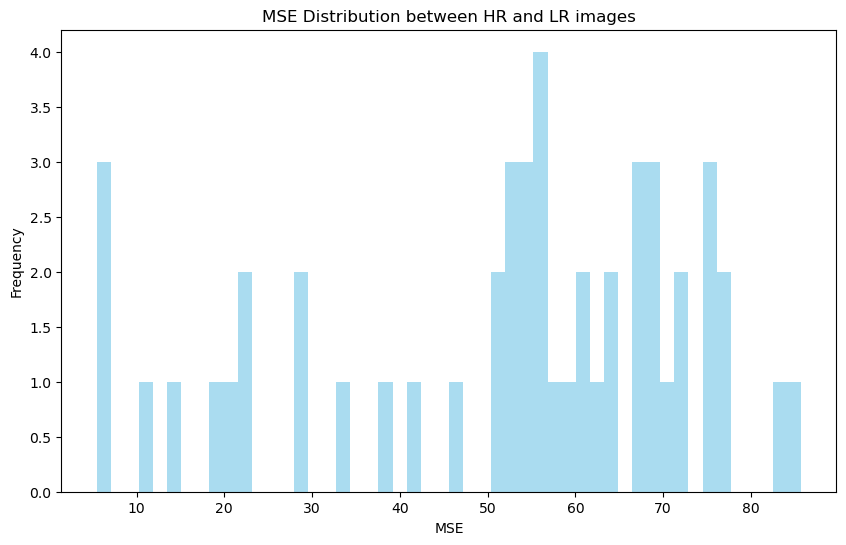

In [28]:
# Function to calculate MSE
def calculate_mse(hr_image, lr_image):
    mse = np.mean((hr_image - lr_image) ** 2)
    return mse

# Function to get MSE distribution for a set of images
def get_mse_distribution(hr_directory, lr_directory, n=50):
    mses = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            mse = calculate_mse(hr_img_array, lr_img_array)
            mses.append(mse)
    return mses

mse_distribution = get_mse_distribution(train_hr_path, train_lr_path)
plt.figure(figsize=(10, 6))
plt.hist(mse_distribution, bins=50, color='skyblue', alpha=0.7)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE Distribution between HR and LR images')
plt.show()


### Visual comparison of quality difference between HR and LR image

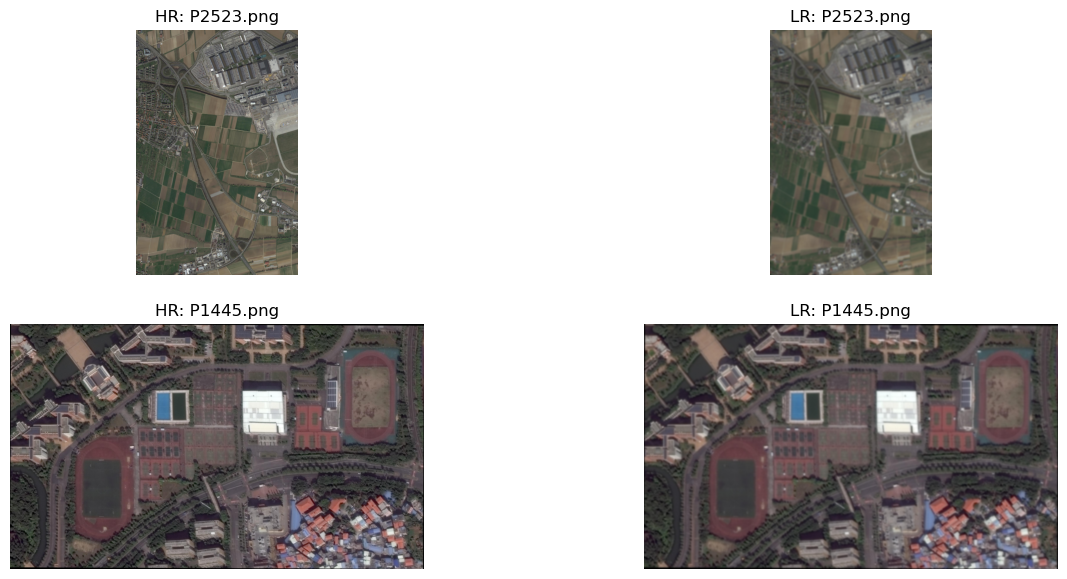

In [17]:

# Function to display HR and LR images side by side
def display_hr_lr_comparison(hr_directory, lr_directory, n=2):
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    plt.figure(figsize=(15, 7))
    for i, file in enumerate(hr_filesdddd):
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            plt.subplot(n, 2, 2*i + 1)
            plt.imshow(hr_img)
            plt.axis('off')
            plt.title(f'HR: {file}')
            
            plt.subplot(n, 2, 2*i + 2)
            plt.imshow(lr_img)
            plt.axis('off')
            plt.title(f'LR: {file}')
    plt.show()

display_hr_lr_comparison(train_hr_path, train_lr_path, n=2)

### Quantitative Metrics: PSNR

In [23]:
# Function to calculate PSNR
def calculate_psnr(hr_image, lr_image):
    mse = np.mean((hr_image - lr_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                 # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Function to get average PSNR for a set of images
def get_average_psnr(hr_directory, lr_directory, n=10):
    psnrs = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            psnr = calculate_psnr(hr_img_array, lr_img_array)
            psnrs.append(psnr)
    return np.mean(psnrs)

average_psnr = get_average_psnr(train_hr_path, train_lr_path)
print(f'Average PSNR between HR and LR images: {average_psnr} dB')

Average PSNR between HR and LR images: 33.84169602949733 dB


### Training EDSRModel